# Esercizio

Analizzate il dataset dei sensori IoT allegato e sviluppate un modello predittivo per il consumo energetico. Il vostro compito è identificare eventuali relazioni non lineari tra le variabili, proporre appropriate trasformazioni delle feature ed implementate il modello più opportuno per lo scopo. Documentate il vostro processo di analisi e le vostre conclusioni in un notebook completo.

## Dataset Description

The dataset contains 10,000 records with 21 features related to IoT sensor measurements:

- Environmental variables: temperature, humidity, pressure, dust levels, light intensity
- Device characteristics: device age, device ID, firmware version, maintenance history
- Operating parameters: sampling frequency, signal strength, data encryption
- Performance metrics: CPU cycles, memory usage, energy consumption (target variable)

## 1. Setup dell'Ambiente e Caricamento dei Dati

Iniziamo importando le librerie necessarie e configurando l'ambiente di lavoro. In questo notebook utilizzeremo pandas per la manipolazione dei dati, numpy per operazioni matematiche, e seaborn/matplotlib per le visualizzazioni.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE, RFECV

# Impostazioni di visualizzazione
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
pd.set_option('display.max_columns', None)
np.set_printoptions(precision=3, suppress=True)

# Caricamento del dataset
df = pd.read_csv('iot_sensor_dataset.csv')


Dopo aver importato le librerie, carichiamo il dataset IoT che contiene varie misurazioni di sensori e informazioni sui dispositivi. Il dataset include variabili come temperatura ambientale, intensità del segnale, età del dispositivo e consumo energetico, che sarà la nostra variabile target.

## 2. Esplorazione Iniziale dei Dati
Facciamo una prima analisi esplorativa del dataset per comprenderne la struttura e le caratteristiche principali.

In [39]:

# Visualizzazione delle prime righe
print("Panoramica del dataset:")
print(f"Dimensioni: {df.shape}")
print("\nPrime 5 righe:")
print(df.head())

# Informazioni sui tipi di dati e valori mancanti
print("\nInformazioni sul dataset:")
print(df.info())

# Statistiche descrittive
print("\nStatistiche descrittive:")
print(df.describe())

Panoramica del dataset:
Dimensioni: (10000, 21)

Prime 5 righe:
   ambient_temperature  sampling_frequency  signal_strength  device_age  \
0            25.973713           19.954055       -77.191891   15.638192   
1            20.893886            7.078132       -85.421017  162.602114   
2            27.181508            5.236645       -62.469972   36.750846   
3            34.184239            6.562283       -95.602938  147.664778   
4            20.126773           35.389292       -74.017591  104.289295   

    humidity  light_intensity  vibration_level  device_id firmware_version  \
0  40.404672       555.609812         0.692885          8             v2.0   
1  74.270838       928.340653         0.198886          4             v2.0   
2  29.000585       728.246399         0.455055          9             v2.0   
3  77.607516      3101.854739         0.628558          8             v1.0   
4  63.762251      3235.445541         0.704064          8             v1.2   

   last_maintena

I risultati mostrano che il dataset contiene 10.000 osservazioni con 21 variabili. Non sono presenti valori mancanti e la maggior parte delle variabili sono di tipo numerico (float64 o int64), con una sola variabile di tipo object (firmware_version).

## 3. Visualizzazione della Distribuzione della Variabile Target

Prima di esplorare le relazioni tra variabili, analizziamo la distribuzione della nostra variabile target: il consumo energetico.

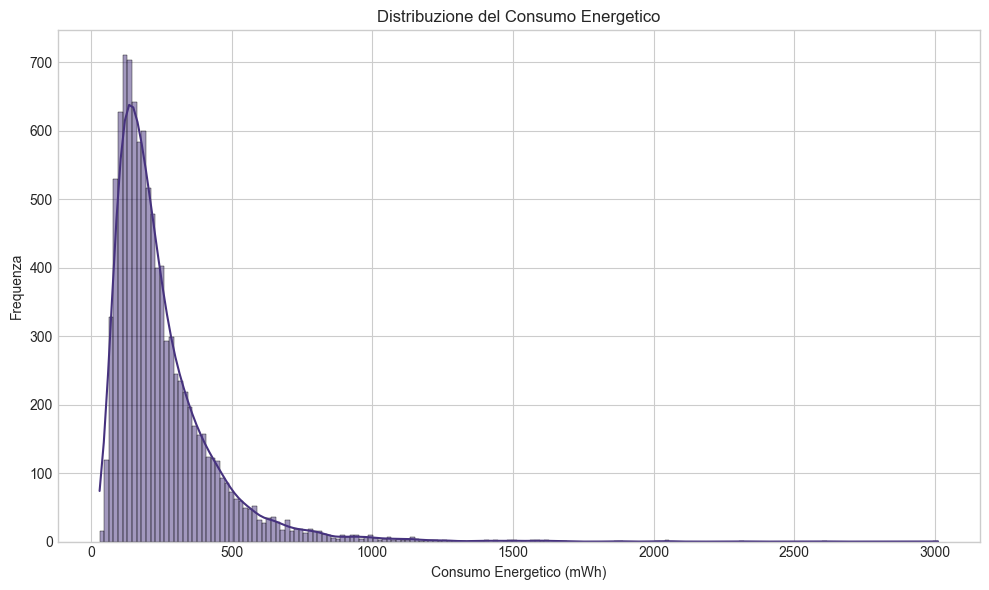

In [23]:
# Distribuzione della variabile target: energy_consumption
plt.figure(figsize=(10, 6))
sns.histplot(df['energy_consumption'], kde=True)
plt.title('Distribuzione del Consumo Energetico')
plt.xlabel('Consumo Energetico (mWh)')
plt.ylabel('Frequenza')
plt.tight_layout()
plt.show()

## 4. Visualizzazione delle Distribuzioni delle Features

Ora visualizziamo le distribuzioni di tutte le features numeriche per capire meglio la natura dei dati.

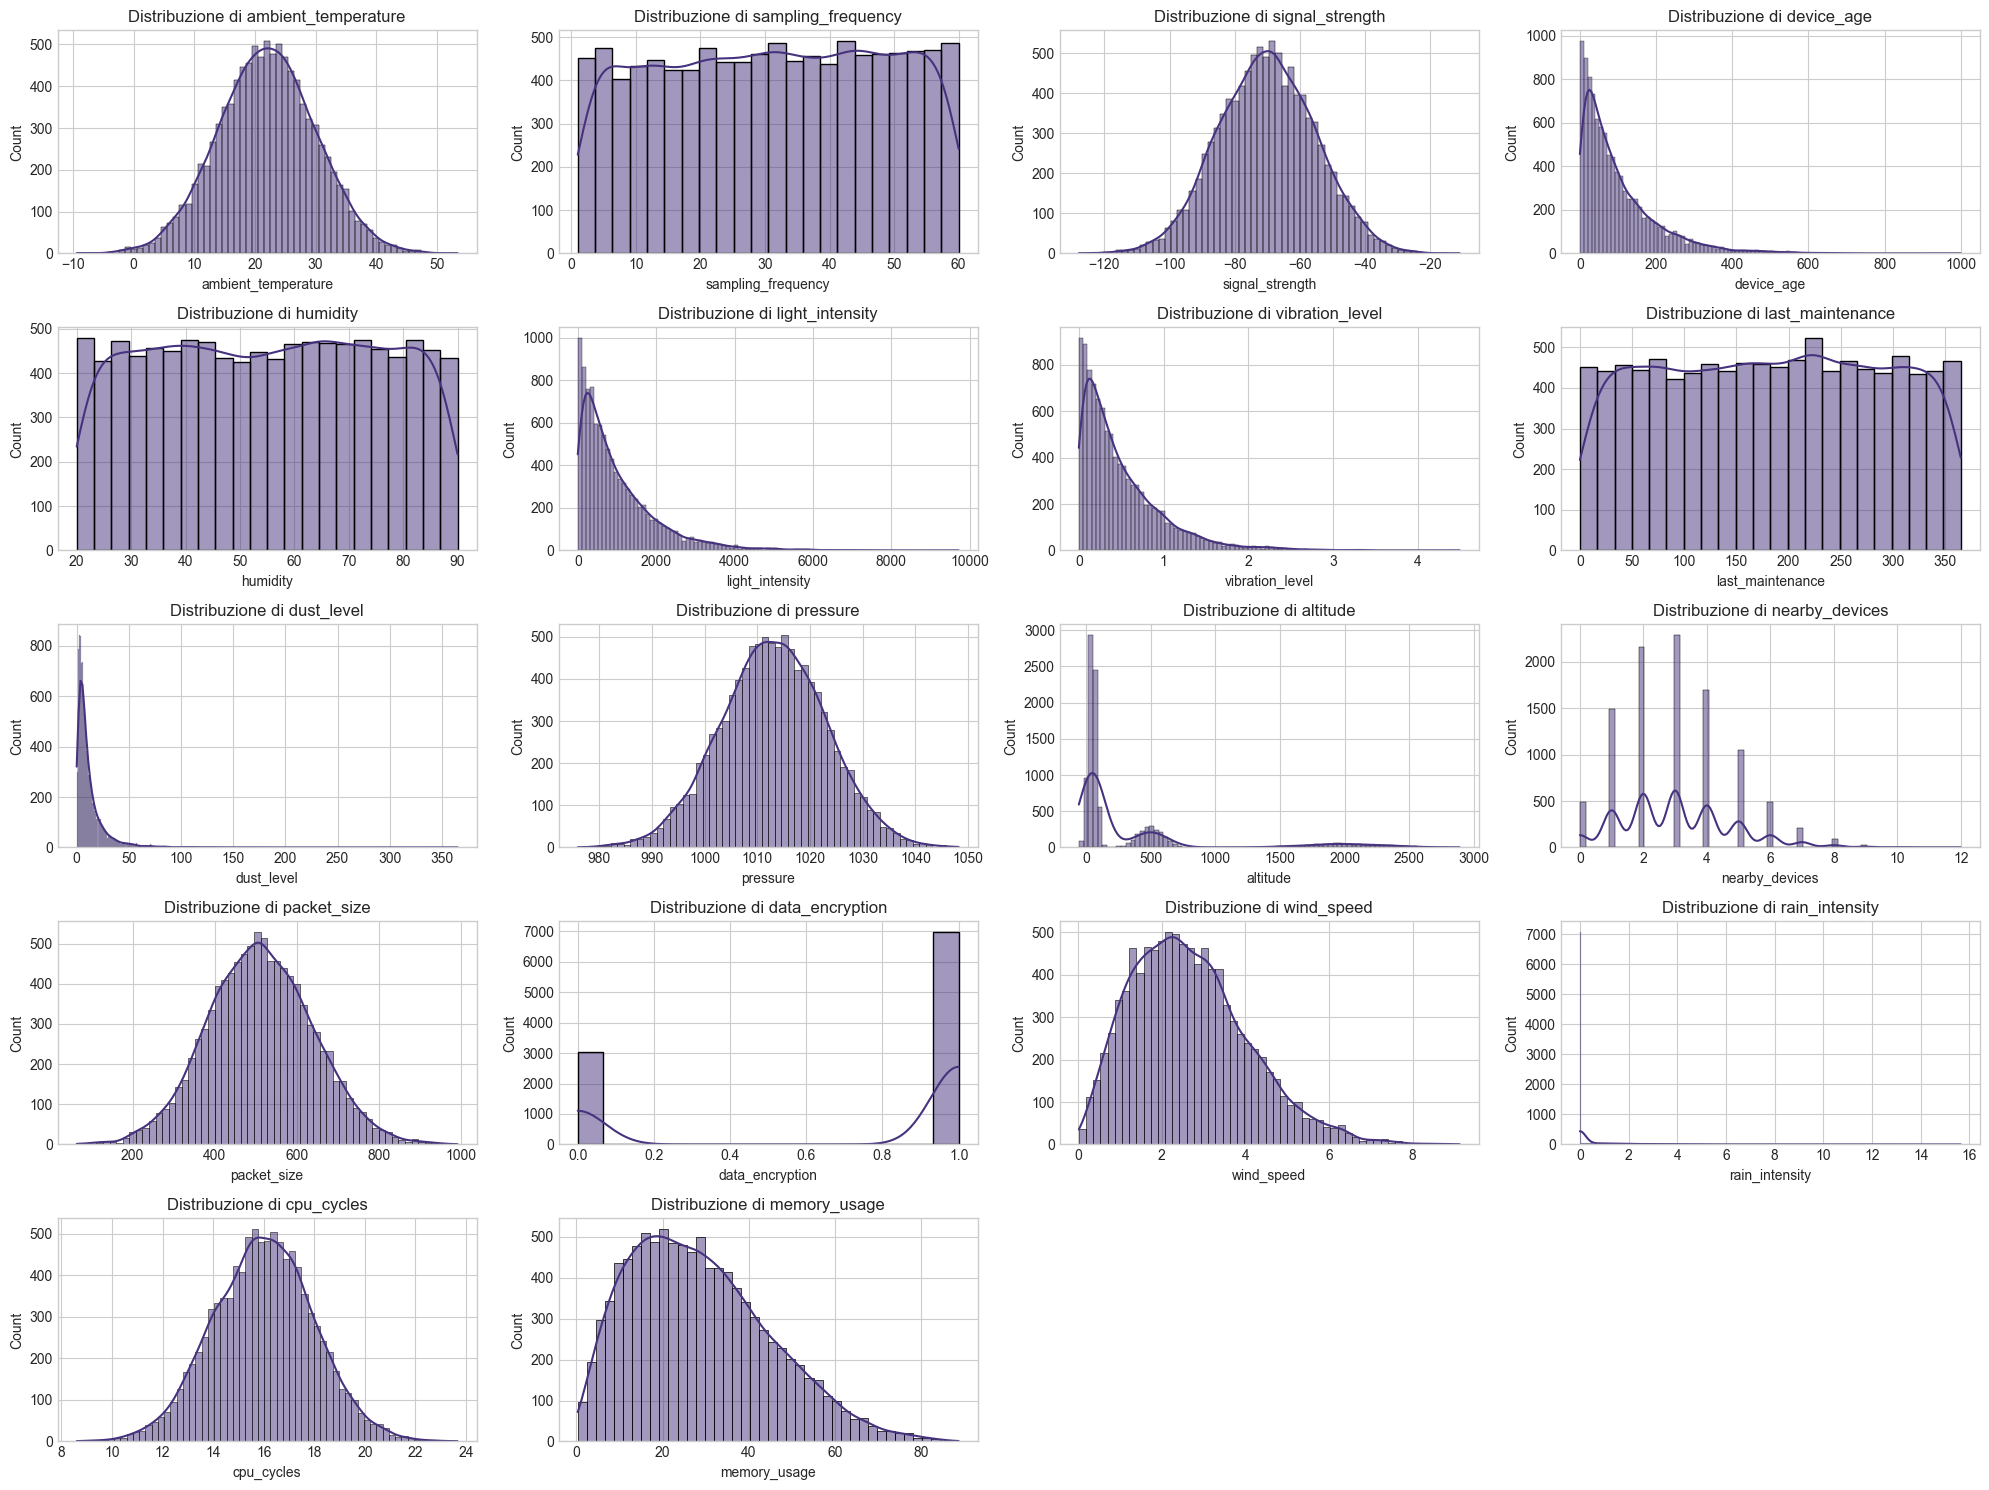

In [24]:
# Creiamo una griglia di istogrammi per visualizzare la distribuzione di tutte le features numeriche
# Escludiamo categoriche e target
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
if 'energy_consumption' in numeric_features:
    numeric_features.remove('energy_consumption')
if 'device_id' in numeric_features:
    numeric_features.remove('device_id')  # Categoria numerica

# Creiamo una griglia 5x4 per visualizzare fino a 20 features
plt.figure(figsize=(20, 15))
for i, feature in enumerate(numeric_features):
    if i < 20:
        plt.subplot(5, 4, i+1)
        sns.histplot(df[feature], kde=True)
        plt.title(f'Distribuzione di {feature}')
plt.tight_layout()
plt.show()

La visualizzazione delle distribuzioni delle singole variabili ci aiuta a comprendere come sono distribuite e se presentano caratteristiche particolari come asimmetrie o multimodalità. Queste informazioni sono importanti per scegliere le trasformazioni appropriate in fase di modellazione.

## 5. Analisi delle Correlazioni Lineari

Iniziamo analizzando le correlazioni lineari tra le variabili utilizzando il coefficiente di correlazione di Pearson

Correlazioni lineari (Pearson) con energy_consumption:
energy_consumption     1.000000
packet_size            0.024686
humidity               0.020290
device_age             0.018935
sampling_frequency     0.017869
rain_intensity         0.010045
nearby_devices         0.009263
memory_usage           0.007637
wind_speed             0.007316
data_encryption        0.005021
dust_level             0.003433
cpu_cycles            -0.003062
light_intensity       -0.003673
vibration_level       -0.004052
last_maintenance      -0.005304
pressure              -0.006386
altitude              -0.015701
device_id             -0.019275
ambient_temperature   -0.027349
signal_strength       -0.865221
Name: energy_consumption, dtype: float64


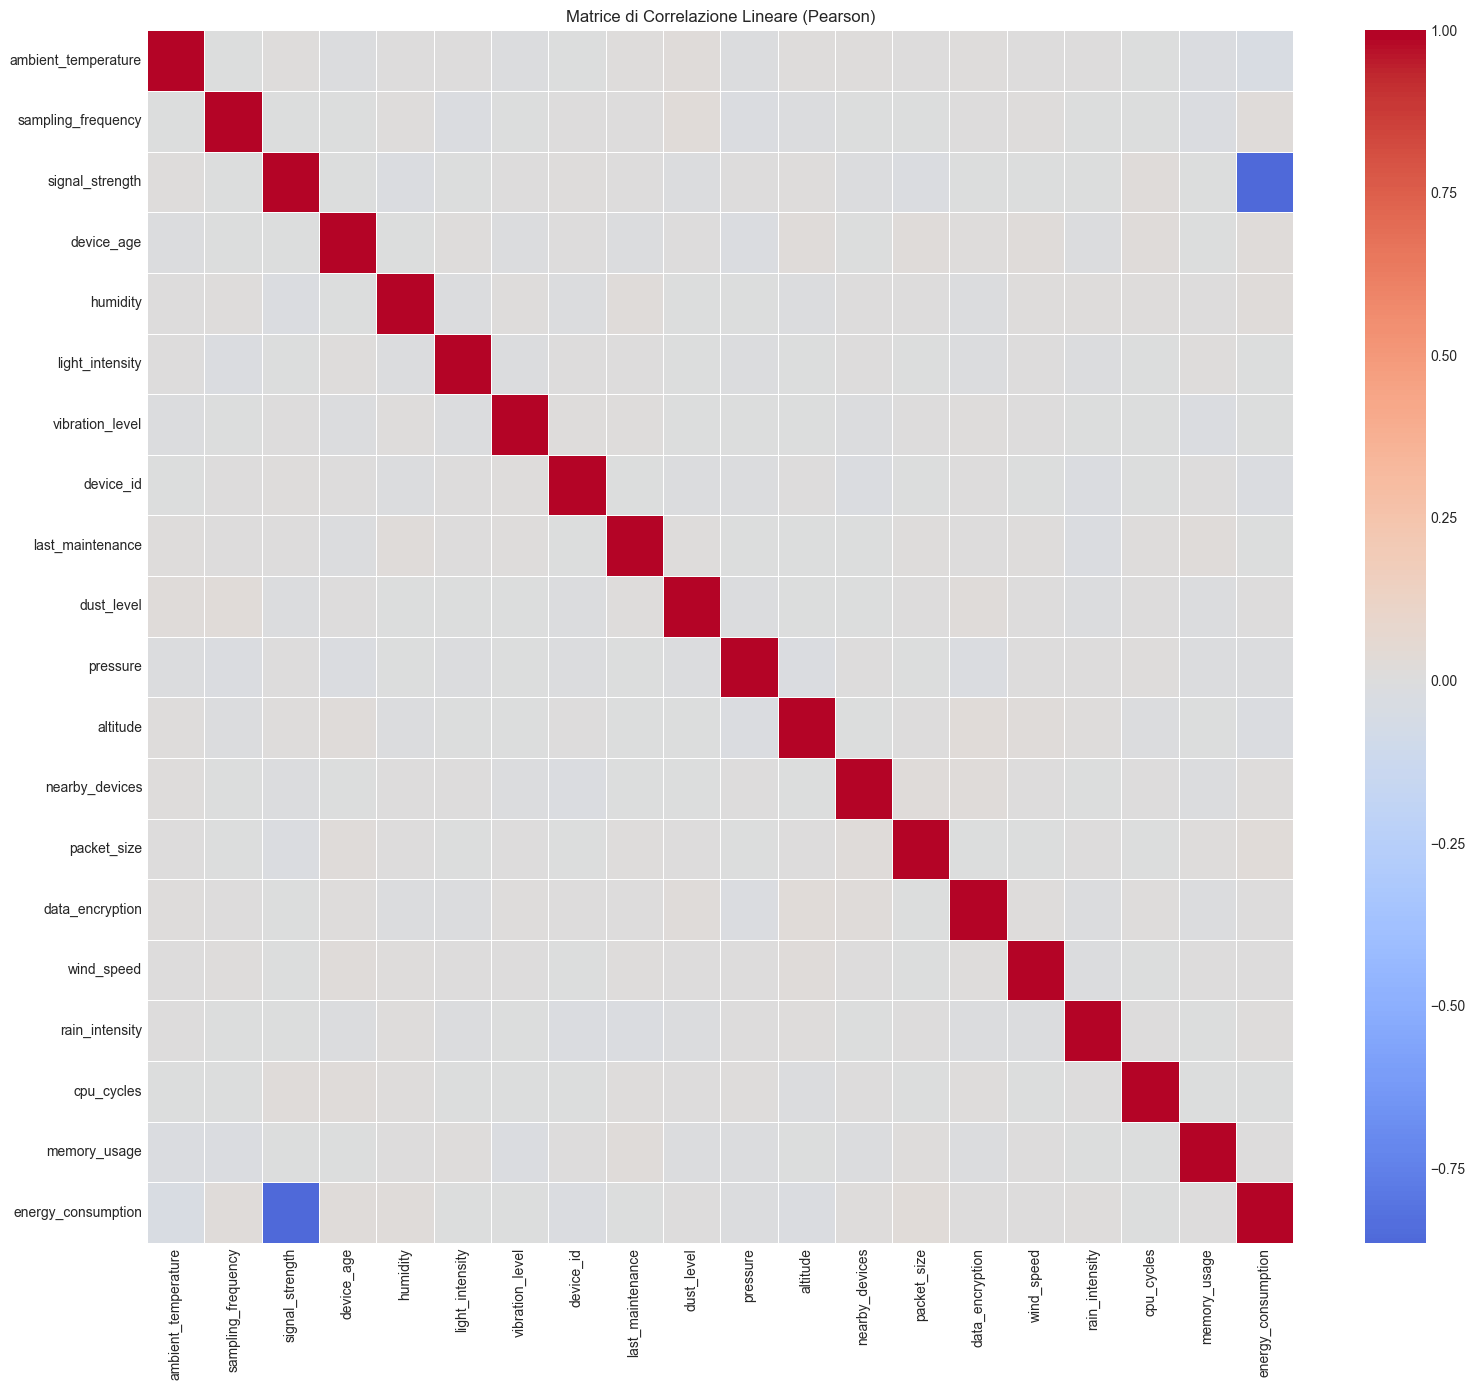

In [25]:
# Selezioniamo solo le colonne numeriche per il calcolo della correlazione
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = df[numeric_columns].corr(method='pearson')

# Visualizziamo le correlazioni con la variabile target
target_correlations = correlation_matrix['energy_consumption'].sort_values(ascending=False)
print("Correlazioni lineari (Pearson) con energy_consumption:")
print(target_correlations)

# Visualizziamo la matrice di correlazione come heatmap
# Limitiamo il numero di features nella heatmap per maggiore leggibilità
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, 
            linewidths=0.5)
plt.title('Matrice di Correlazione Lineare (Pearson)')
plt.tight_layout()
plt.show()

L'analisi delle correlazioni di Pearson evidenzia quale variabile ha una forte correlazione lineare (positiva o negativa) con il consumo energetico. In particolare, notiamo che `signal_strength` ha una forte correlazione negativa (-0.865) con il consumo energetico. Questo significa che un segnale più debole (valori più negativi) è associato a un maggiore consumo energetico, il che è logico dal punto di vista fisico.

Le altre variabili mostrano correlazioni lineari molto più deboli. Questo potrebbe indicare che le relazioni sono non lineari o che queste variabili non hanno una forte influenza sul consumo energetico.


## 6. Analisi delle Correlazioni Monotoniche

Le correlazioni di Pearson catturano solo relazioni lineari. Utilizziamo ora il coefficiente di correlazione di Spearman per individuare relazioni monotoniche anche non lineari.


Correlazioni monotoniche (Spearman) con energy_consumption:
energy_consumption     1.000000
sampling_frequency     0.023454
device_age             0.021735
packet_size            0.016440
humidity               0.013401
nearby_devices         0.010447
light_intensity        0.009337
wind_speed             0.003192
memory_usage           0.003119
data_encryption        0.003072
rain_intensity        -0.001402
vibration_level       -0.002927
pressure              -0.003175
dust_level            -0.003401
last_maintenance      -0.007868
altitude              -0.012186
device_id             -0.012753
cpu_cycles            -0.019027
ambient_temperature   -0.025258
signal_strength       -0.996756
Name: energy_consumption, dtype: float64


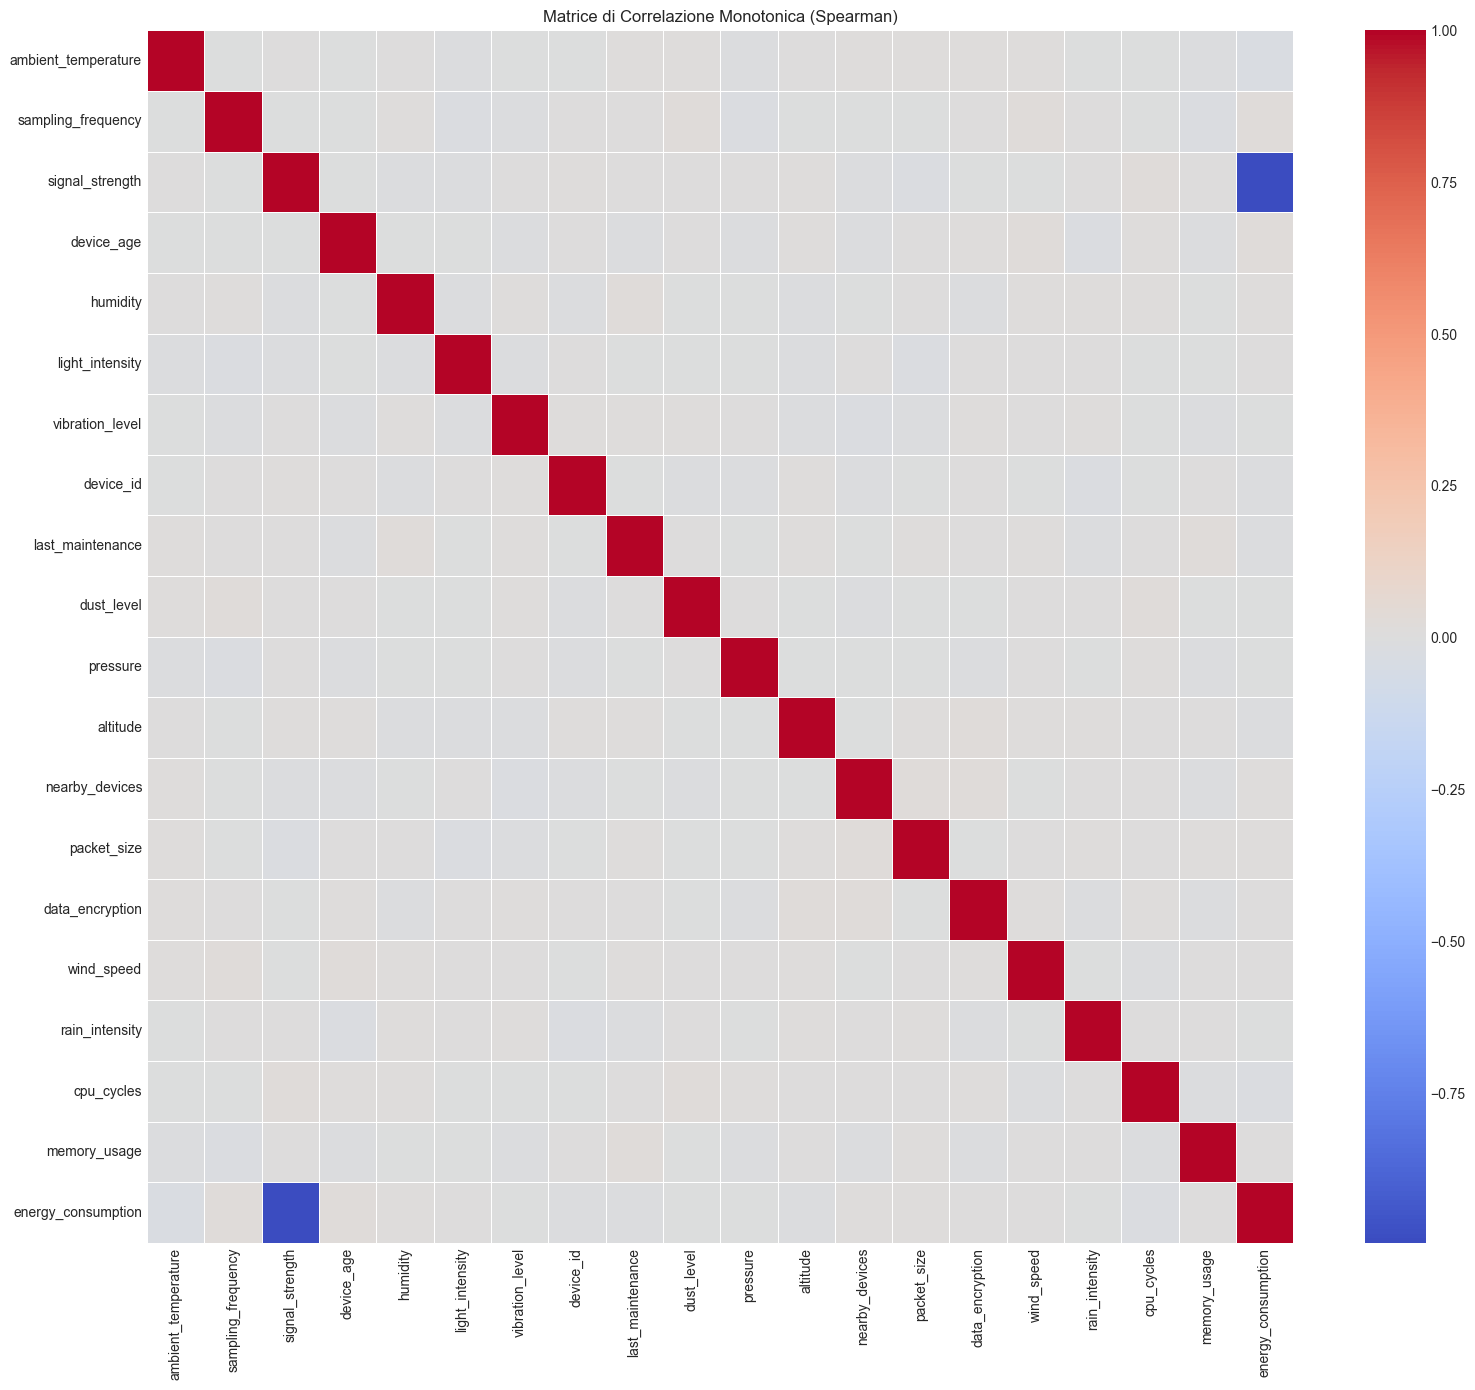


Differenze tra correlazioni Pearson e Spearman (ordinate per differenza):
                      Pearson  Spearman  Difference
signal_strength     -0.865221 -0.996756    0.131534
cpu_cycles          -0.003062 -0.019027    0.015965
light_intensity     -0.003673  0.009337    0.013010
rain_intensity       0.010045 -0.001402    0.011448
packet_size          0.024686  0.016440    0.008246
humidity             0.020290  0.013401    0.006889
dust_level           0.003433 -0.003401    0.006834
device_id           -0.019275 -0.012753    0.006522
sampling_frequency   0.017869  0.023454    0.005585
memory_usage         0.007637  0.003119    0.004518
wind_speed           0.007316  0.003192    0.004123
altitude            -0.015701 -0.012186    0.003515
pressure            -0.006386 -0.003175    0.003212
device_age           0.018935  0.021735    0.002800
last_maintenance    -0.005304 -0.007868    0.002565
ambient_temperature -0.027349 -0.025258    0.002091
data_encryption      0.005021  0.003072  

In [26]:
# Calcoliamo la correlazione di Spearman
spearman_corr = df[numeric_columns].corr(method='spearman')
spearman_target = spearman_corr['energy_consumption'].sort_values(ascending=False)

print("\nCorrelazioni monotoniche (Spearman) con energy_consumption:")
print(spearman_target)

# Visualizziamo la matrice di correlazione di Spearman
plt.figure(figsize=(16, 14))
sns.heatmap(spearman_corr, annot=False, cmap='coolwarm', center=0, 
            linewidths=0.5)
plt.title('Matrice di Correlazione Monotonica (Spearman)')
plt.tight_layout()
plt.show()

# Confrontiamo Pearson e Spearman per vedere le differenze
comparison = pd.DataFrame({
    'Pearson': target_correlations,
    'Spearman': spearman_target
})
comparison['Difference'] = abs(comparison['Spearman'] - comparison['Pearson'])
print("\nDifferenze tra correlazioni Pearson e Spearman (ordinate per differenza):")
print(comparison.sort_values('Difference', ascending=False))

La correlazione di Spearman per `signal_strength` è ancora più forte (-0.997) rispetto alla correlazione di Pearson, suggerendo una relazione fortemente monotonica ma non perfettamente lineare. La tabella delle differenze evidenzia le variabili per cui le correlazioni di Pearson e Spearman differiscono maggiormente, indicando potenziali relazioni non lineari.

## 7. Identificazione di Relazioni Non Lineari con Mutual Information

Per individuare relazioni non lineari complesse che potrebbero non essere catturate nemmeno dalla correlazione di Spearman, utilizziamo la Mutual Information, una misura che può rilevare altri tipi di dipendenza statistica.


La mutual information è una misura della dipendenza statistica tra due variabili casuali. Essa quantifica la "quantità di informazione" (misurata in bit) che si ottiene su una variabile osservando l'altra.


Matematicamente, la mutual information tra due variabili casuali X e Y è definita come:

$$I(X;Y) = \sum_{y \in Y} \sum_{x \in X} p(x,y) \log \left( \frac{p(x,y)}{p(x)p(y)} \right)$$

Dove:

- $p(x,y)$ è la probabilità congiunta
- $p(x)$ e $p(y)$ sono le probabilità marginali



Differenze

|Misura|Tipo di relazione|Range|Interpretazione|
|---|---|---|---|
|**Mutual Information**|Qualsiasi dipendenza statistica (lineare e non lineare)|[0, +∞)|Quantità di informazione condivisa tra le variabili; valore alto indica forte dipendenza, ma senza indicare direzione o forma della relazione|
|**Pearson**|Solo relazioni lineari|[-1, +1]|Misura la forza e direzione della relazione lineare; +1 indica correlazione lineare positiva perfetta, -1 correlazione negativa perfetta, 0 assenza di relazione lineare|
|**Spearman**|Relazioni monotone|[-1, +1]|Misura la forza e direzione della relazione monotona tra i ranghi delle variabili; +1 indica relazione monotona crescente perfetta, -1 decrescente perfetta, 0 assenza di monotonicità|



Mutual Information con energy_consumption (cattura relazioni non lineari complesse):
                Feature  Mutual Information
2       signal_strength            0.282349
9            dust_level            0.001315
5       light_intensity            0.001223
1    sampling_frequency            0.000900
15           wind_speed            0.000412
18         memory_usage            0.000319
16       rain_intensity            0.000314
10             pressure            0.000219
14      data_encryption            0.000181
7             device_id            0.000011
0   ambient_temperature            0.000000
8      last_maintenance            0.000000
3            device_age            0.000000
4              humidity            0.000000
6       vibration_level            0.000000
13          packet_size            0.000000
12       nearby_devices            0.000000
11             altitude            0.000000
17           cpu_cycles            0.000000


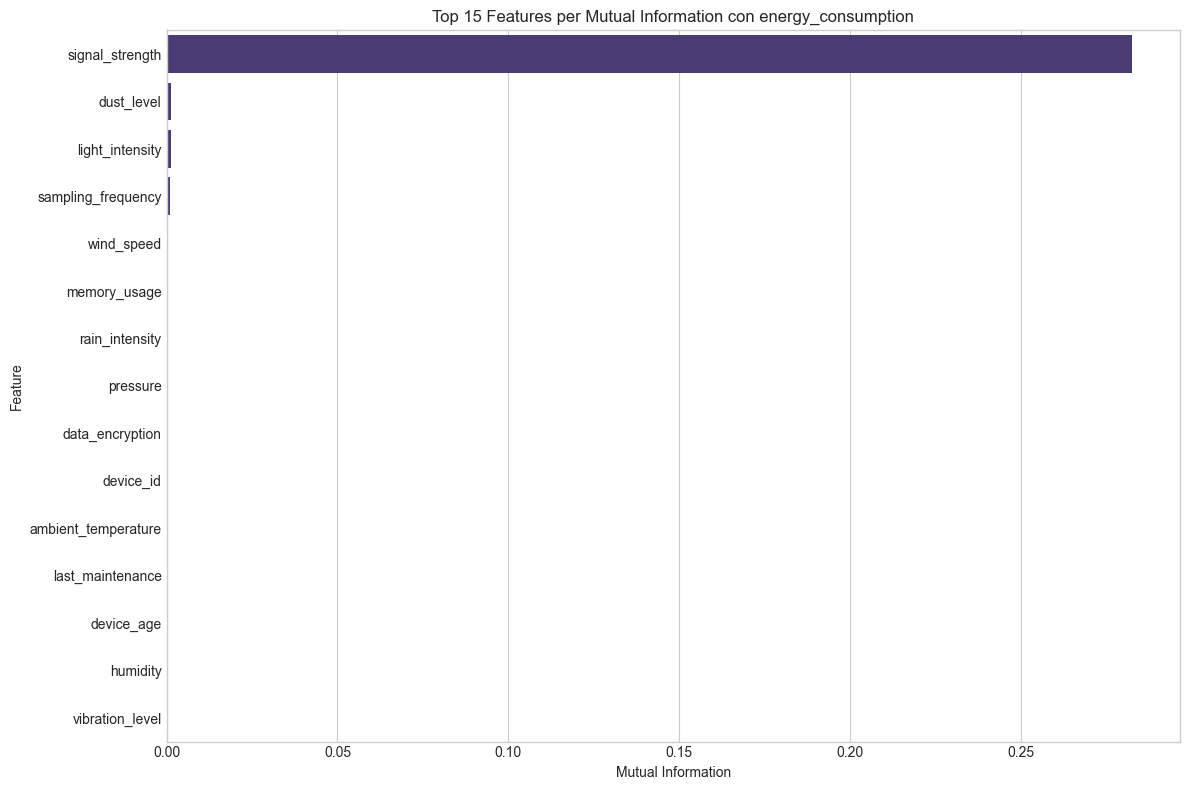

In [27]:
from sklearn.feature_selection import mutual_info_regression

# Calcoliamo la Mutual Information per variabili continue
X = df[numeric_columns.drop('energy_consumption')]
y = df['energy_consumption']

# Normalizzazione della Mutual Information tra 0 e 1 per renderla comparabile
def normalize_mi(mi, y):
    return mi / (np.log(2) + np.log(len(y)))

mi_scores = mutual_info_regression(X, y)
mi_scores = normalize_mi(mi_scores, y)

# Creiamo un DataFrame con i risultati
mi_df = pd.DataFrame({
    'Feature': X.columns,
    'Mutual Information': mi_scores
}).sort_values('Mutual Information', ascending=False)

print("\nMutual Information con energy_consumption (cattura relazioni non lineari complesse):")
print(mi_df)

# Visualizziamo i risultati
plt.figure(figsize=(12, 8))
sns.barplot(x='Mutual Information', y='Feature', data=mi_df.head(15))
plt.title('Top 15 Features per Mutual Information con energy_consumption')
plt.tight_layout()
plt.show()

# Confronto completo tra le diverse misure di correlazione
comparison_full = pd.DataFrame({
    'Feature': X.columns,
    'Pearson': [target_correlations[col] for col in X.columns],
    'Spearman': [spearman_target[col] for col in X.columns],
    'Mutual Information': mi_scores
})

La Mutual Information conferma che `signal_strength` è la variabile con la relazione più forte con il consumo energetico. Alcune variabili che mostravano correlazioni basse con Pearson e Spearman presentano valori di Mutual Information più elevati, suggerendo la presenza di relazioni non lineari.

## 8. Confronto tra Diverse Misure di Correlazione

Confrontiamo ora tutte le misure di correlazione per avere una visione completa delle relazioni tra le variabili.


Confronto tra diverse misure di correlazione:
                Feature   Pearson  Spearman  Mutual Information  Pearson_abs  \
2       signal_strength -0.865221 -0.996756            0.282349     0.865221   
9            dust_level  0.003433 -0.003401            0.001315     0.003433   
5       light_intensity -0.003673  0.009337            0.001223     0.003673   
1    sampling_frequency  0.017869  0.023454            0.000900     0.017869   
15           wind_speed  0.007316  0.003192            0.000412     0.007316   
18         memory_usage  0.007637  0.003119            0.000319     0.007637   
16       rain_intensity  0.010045 -0.001402            0.000314     0.010045   
10             pressure -0.006386 -0.003175            0.000219     0.006386   
14      data_encryption  0.005021  0.003072            0.000181     0.005021   
7             device_id -0.019275 -0.012753            0.000011     0.019275   
0   ambient_temperature -0.027349 -0.025258            0.000000     0.027

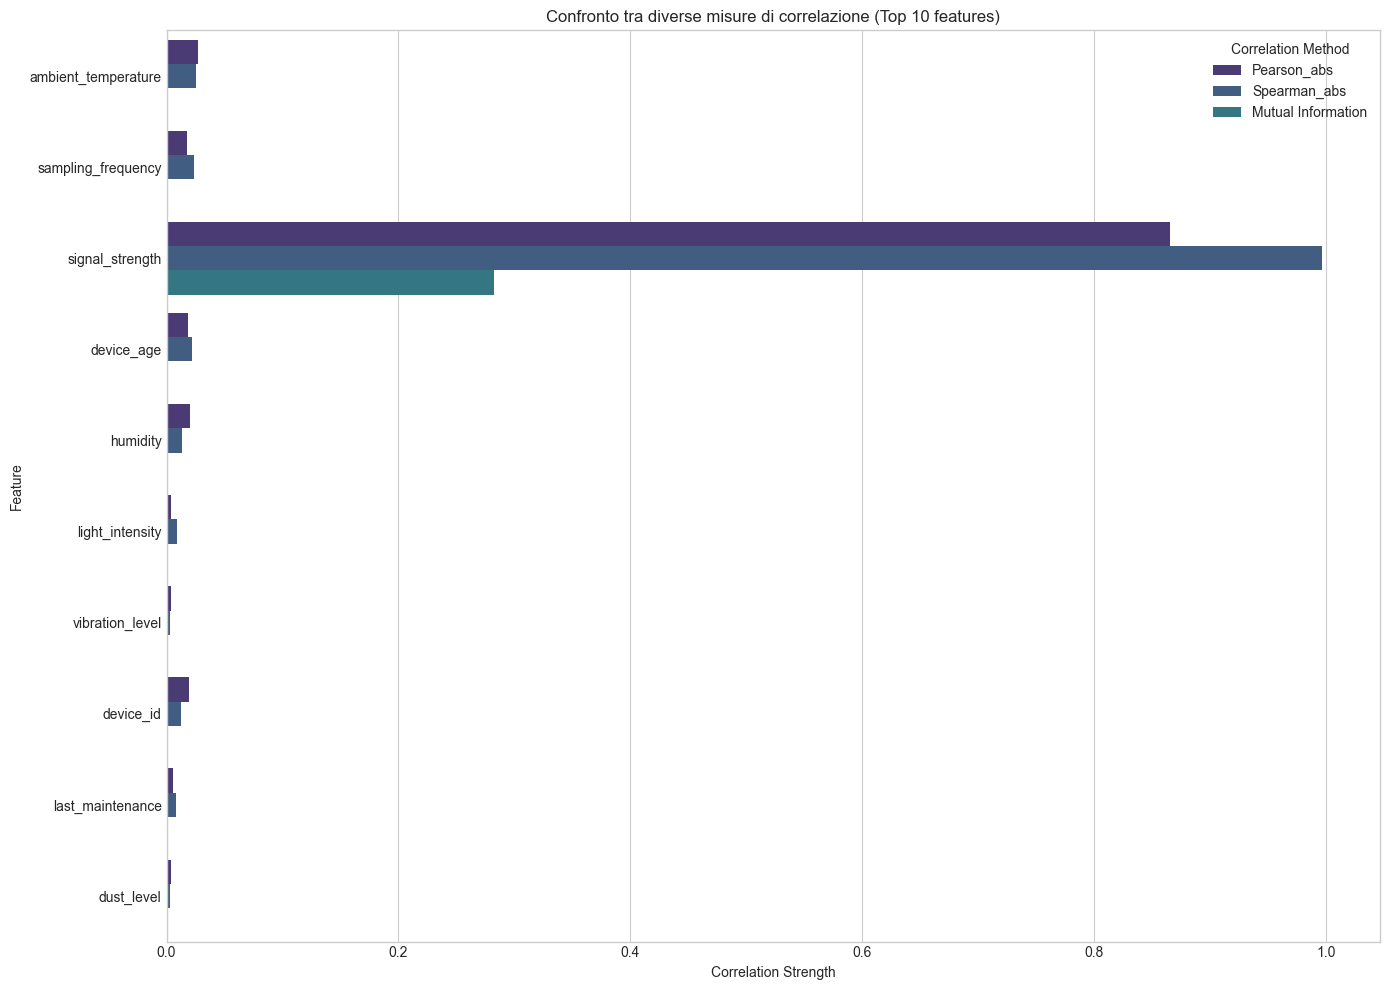

In [28]:
# Normalizziamo Pearson e Spearman per renderli confrontabili con MI (valori assoluti)
comparison_full['Pearson_abs'] = abs(comparison_full['Pearson'])
comparison_full['Spearman_abs'] = abs(comparison_full['Spearman'])

print("\nConfronto tra diverse misure di correlazione:")
print(comparison_full.sort_values('Mutual Information', ascending=False))

# Visualizziamo il confronto tra le tre misure
plt.figure(figsize=(14, 10))
comparison_plot = comparison_full.head(10).melt(
    id_vars='Feature', 
    value_vars=['Pearson_abs', 'Spearman_abs', 'Mutual Information'],
    var_name='Correlation Method', 
    value_name='Correlation Strength'
)
sns.barplot(x='Correlation Strength', y='Feature', hue='Correlation Method', data=comparison_plot)
plt.title('Confronto tra diverse misure di correlazione (Top 10 features)')
plt.tight_layout()
plt.show()

Il confronto tra le tre misure di correlazione mostra chiaramente le differenze tra loro. Alcune variabili mostrano valori alti solo in una o due delle metriche, suggerendo relazioni di diversa natura.

## 9. Visualizzazione delle Relazioni con Scatter Plot

Per esaminare visivamente le relazioni tra le variabili e il target, creiamo scatter plot per ogni feature.

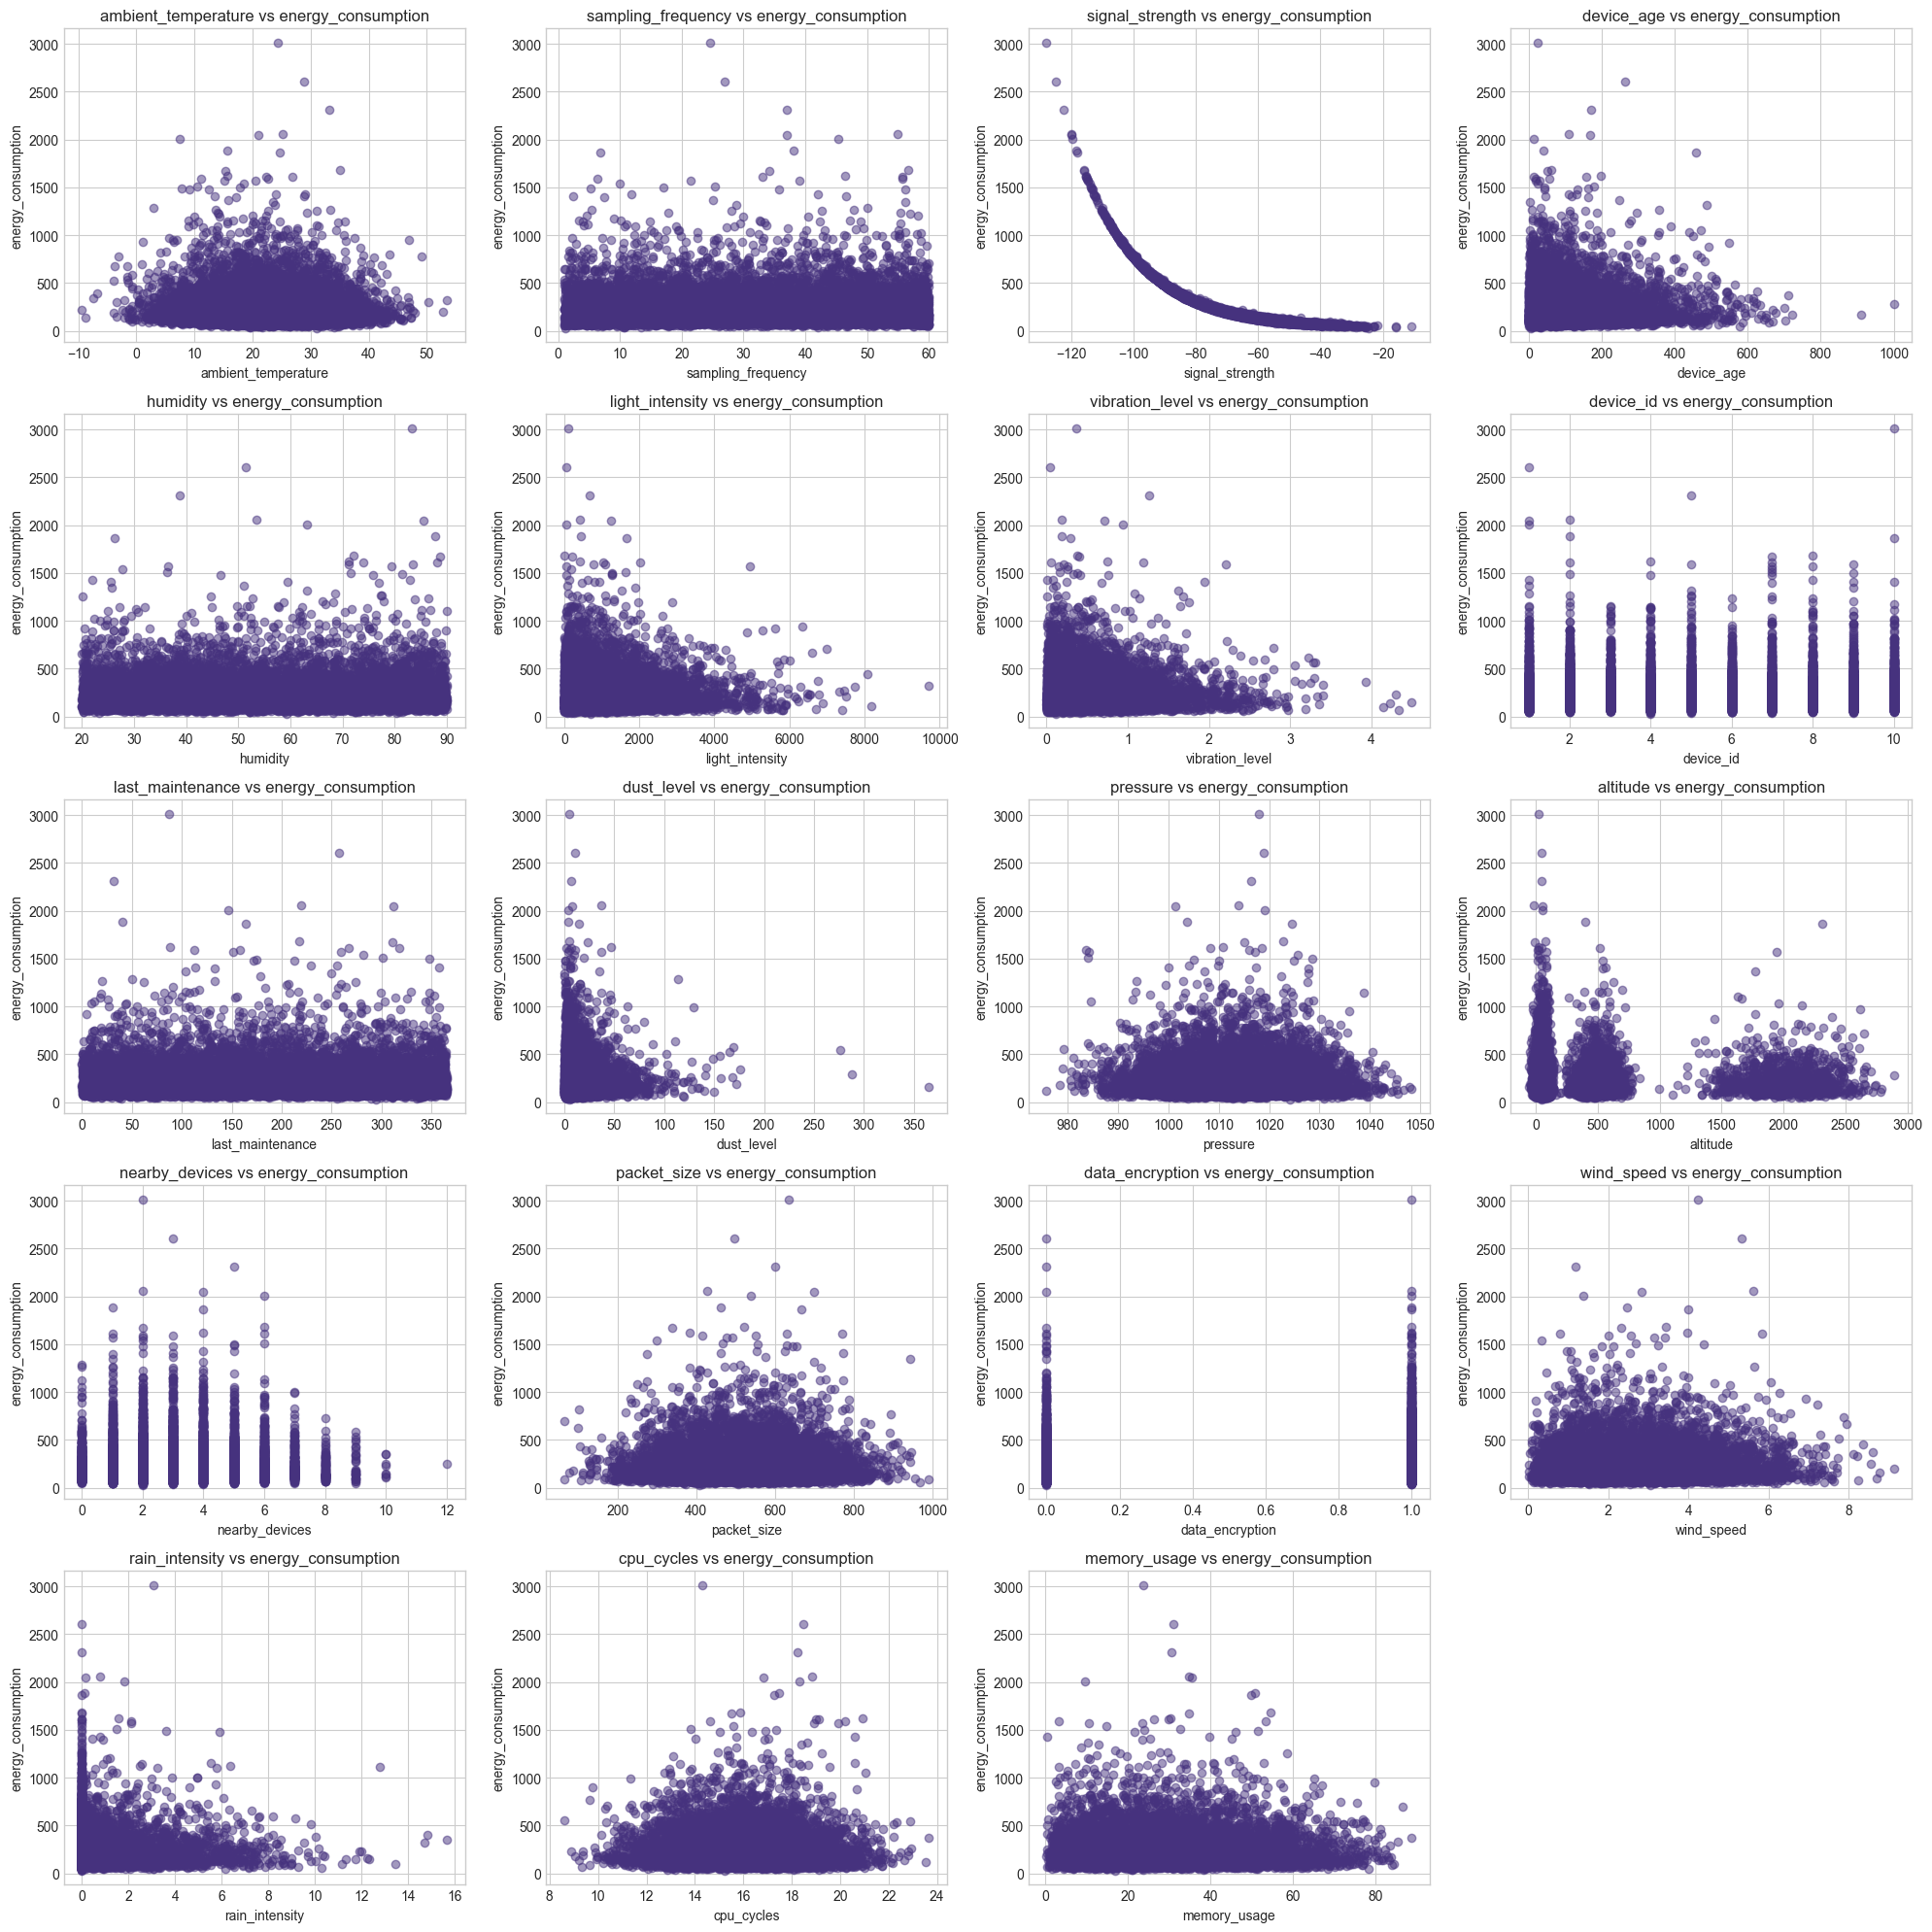

In [40]:
# Creiamo scatter plot per TUTTE le features numeriche vs target
# Utilizziamo solo le features numeriche per gli scatter plot
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_features.remove('energy_consumption')  # Rimuoviamo il target
    
# Calcoliamo quante righe e colonne servono per il subplot grid
n_features = len(numeric_features)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols  # Arrotonda per eccesso

plt.figure(figsize=(20, n_rows * 4))
for i, feature in enumerate(numeric_features):
    plt.subplot(n_rows, n_cols, i+1)
    plt.scatter(df[feature], df['energy_consumption'], alpha=0.5)
    plt.title(f'{feature} vs energy_consumption')
    plt.xlabel(feature)
    plt.ylabel('energy_consumption')
plt.tight_layout()
plt.show()

Gli scatter plot rivelano visivamente la natura delle relazioni tra le variabili e il consumo energetico. Possiamo osservare relazioni non lineari che non sono state catturate completamente dalle correlazioni di Pearson. Ad esempio, `signal_strength` mostra una relazione non lineare evidente con il consumo energetico.


## 10. Trasformazione delle Variabili per Linearizzare le Relazioni

Per migliorare la modellazione, trasformiamo alcune variabili per linearizzare le loro relazioni con il target.

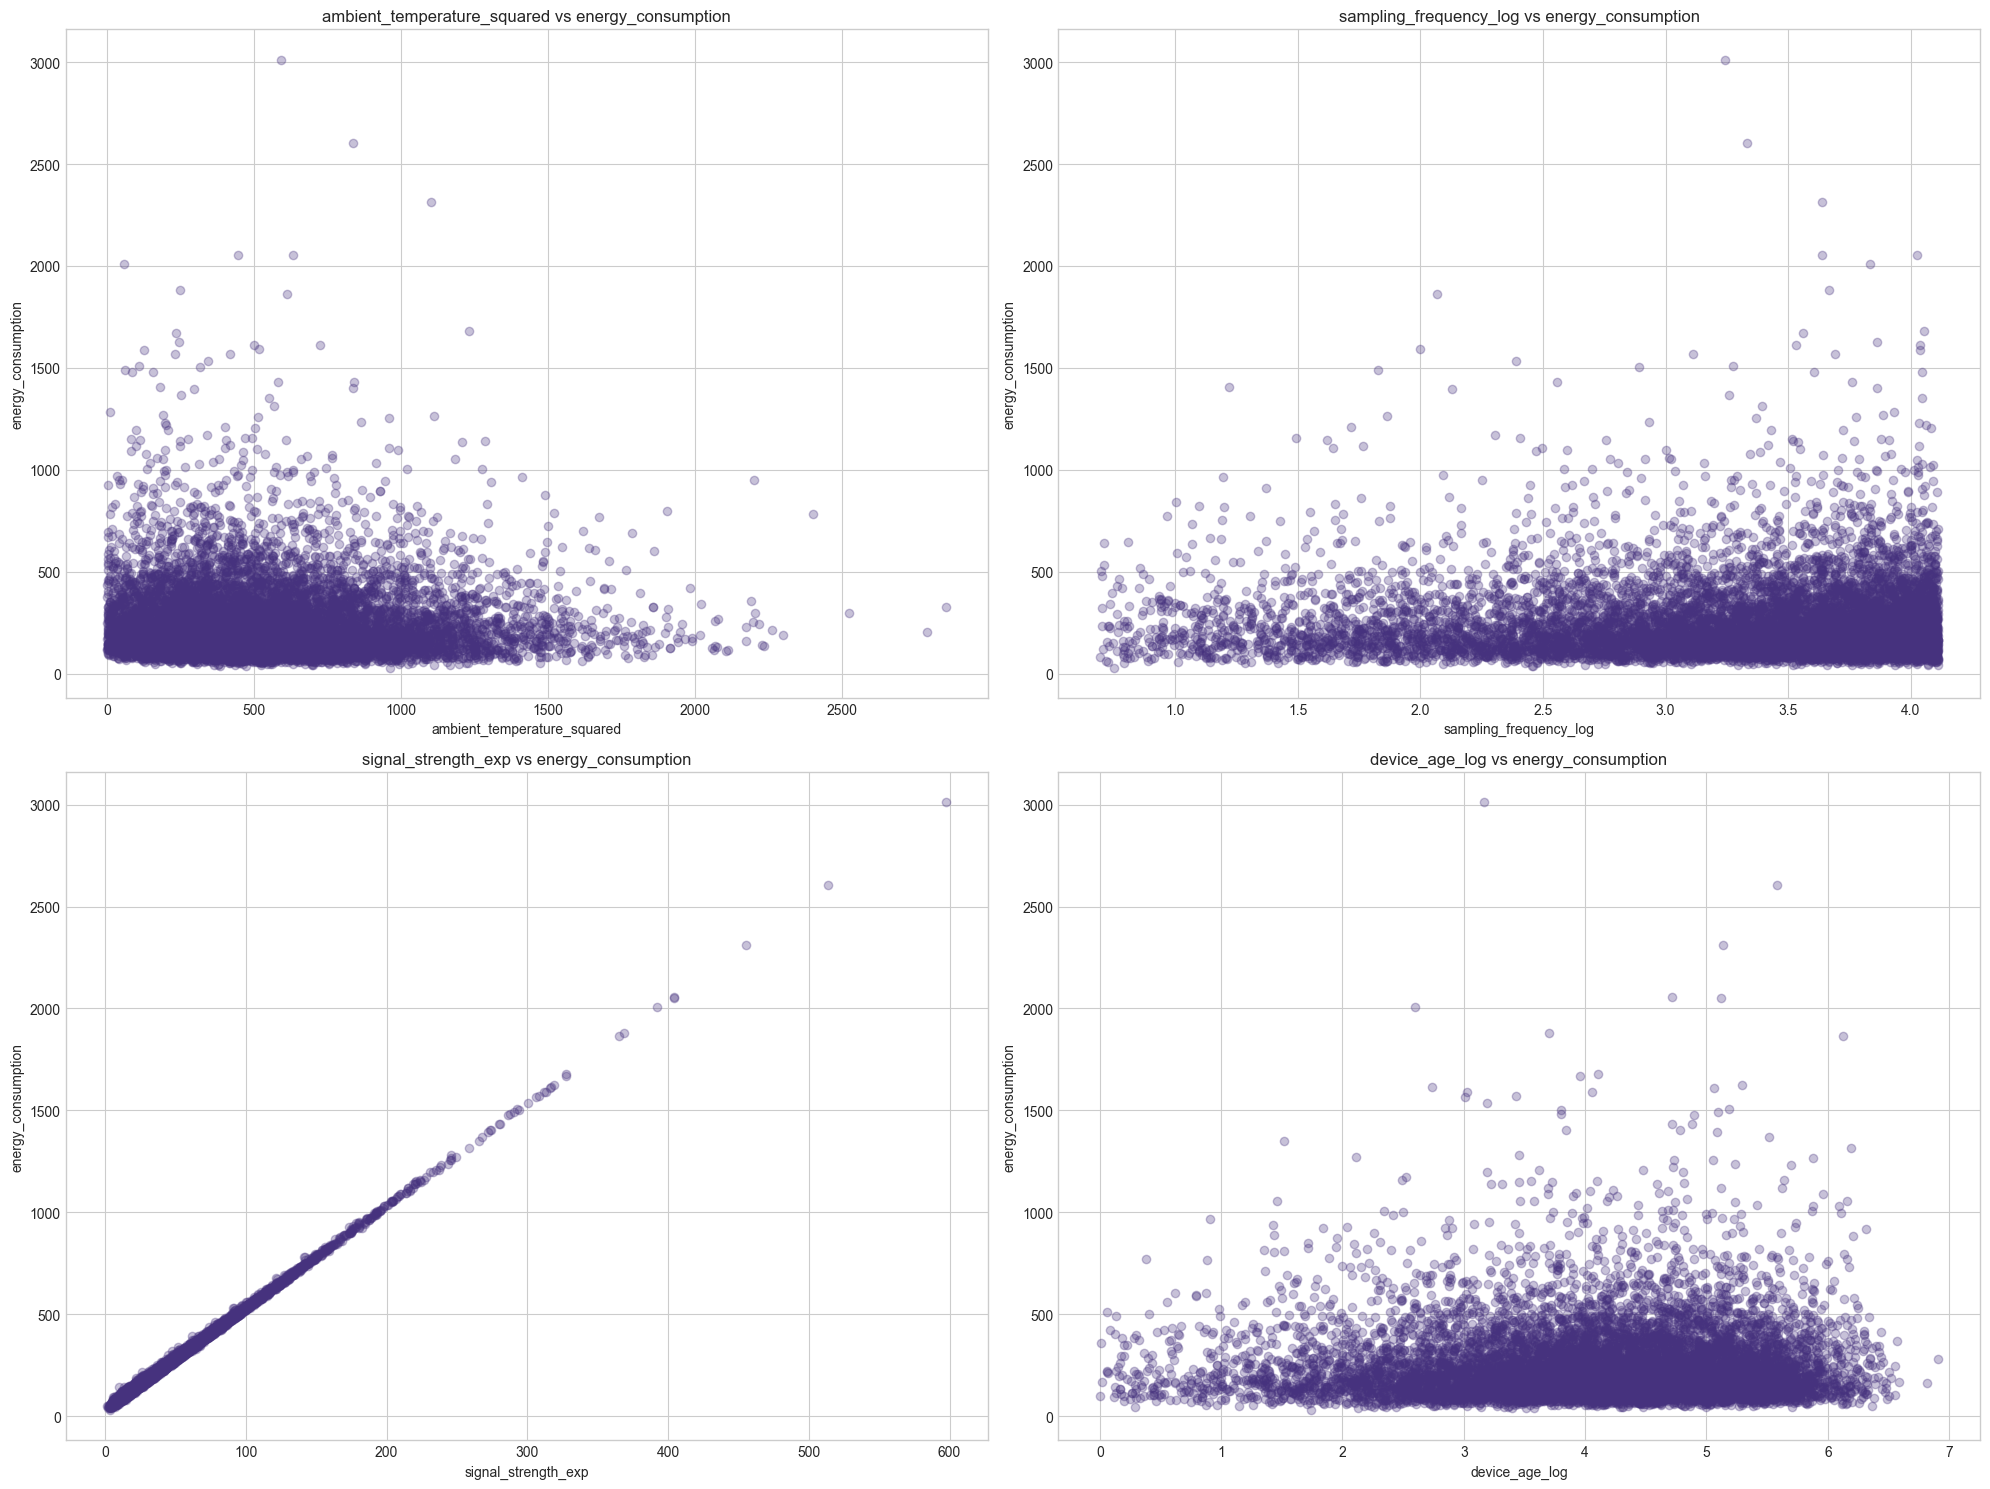

In [43]:
# Creiamo un nuovo dataframe per le trasformazioni
df_transformed = df.copy()

# Trasformazioni quadratiche
df_transformed['ambient_temperature_squared'] = (df['ambient_temperature'])**2

# Trasformazioni logaritmiche (aggiungendo 1 per evitare log(0))
for feature in ['sampling_frequency', 'device_age']:
    df_transformed[f'{feature}_log'] = np.log1p(df[feature])

# Trasformazione esponenziale
df_transformed['signal_strength_exp'] = np.exp(-df['signal_strength'] / 20)  # Dividiamo per una costante di attenuazione

# Visualizziamo le relazioni dopo la trasformazione
plt.figure(figsize=(20, 15))

# Ambient temperature quadratica
plt.subplot(2, 2, 1)
plt.scatter(df_transformed['ambient_temperature_squared'], df['energy_consumption'], alpha=0.3)
plt.title('ambient_temperature_squared vs energy_consumption')
plt.xlabel('ambient_temperature_squared')
plt.ylabel('energy_consumption')

# Sampling frequency logaritmica
plt.subplot(2, 2, 2)
plt.scatter(df_transformed['sampling_frequency_log'], df['energy_consumption'], alpha=0.3)
plt.title('sampling_frequency_log vs energy_consumption')
plt.xlabel('sampling_frequency_log')
plt.ylabel('energy_consumption')

# Signal strength esponenziale
plt.subplot(2, 2, 3)
plt.scatter(df_transformed['signal_strength_exp'], df['energy_consumption'], alpha=0.3)
plt.title('signal_strength_exp vs energy_consumption')
plt.xlabel('signal_strength_exp')
plt.ylabel('energy_consumption')

# Device age logaritmica
plt.subplot(2, 2, 4)
plt.scatter(df_transformed['device_age_log'], df['energy_consumption'], alpha=0.3)
plt.title('device_age_log vs energy_consumption')
plt.xlabel('device_age_log')
plt.ylabel('energy_consumption')

plt.tight_layout()
plt.show()

Le trasformazioni applicate hanno modificato la forma delle relazioni, rendendo alcune più lineari. In particolare, la trasformazione esponenziale di `signal_strength` ha prodotto una relazione quasi perfettamente lineare con il consumo energetico.

## 11. Verifica delle Correlazioni dopo le Trasformazioni

Verifichiamo l'impatto delle trasformazioni calcolando nuovamente le correlazioni.

In [44]:
# Verifichiamo le correlazioni dopo le trasformazioni
transformed_features = ['ambient_temperature_squared', 'sampling_frequency_log', 
                        'signal_strength_exp', 'device_age_log']
correlation_transformed = df_transformed[transformed_features + ['energy_consumption']].corr()

print("\nCorrelazioni delle features trasformate con energy_consumption:")
print(correlation_transformed['energy_consumption'])


Correlazioni delle features trasformate con energy_consumption:
ambient_temperature_squared   -0.022174
sampling_frequency_log         0.016774
signal_strength_exp            0.999094
device_age_log                 0.016583
energy_consumption             1.000000
Name: energy_consumption, dtype: float64


Le correlazioni delle variabili trasformate mostrano un miglioramento significativo. La correlazione tra `signal_strength_exp` e `energy_consumption` è ora quasi perfetta (0.999), indicando che abbiamo trovato la trasformazione giusta per linearizzare questa relazione.

## 12. Implementazione del modello di Regressione Lineare
Implementiamo ora un modello di regressione lineare personalizzato per confrontarlo con un approccio non lineare.

In [45]:
class LinearRegression:
    
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        """
        Inizializzazione del modello
        
        Parametri:
        learning_rate: tasso di apprendimento per la discesa del gradiente
        n_iterations: numero di iterazioni per la discesa del gradiente
        """
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.cost_history = []
    
    def predict(self, X):
        """
        Calcola le previsioni usando il modello lineare y = X*w.
        
        Parametri:
        X -- matrice di input con una colonna di 1 aggiunta per il termine di bias
        
        Restituisce:
        predictions -- vettore delle previsioni
        """
        # Aggiungiamo una colonna di 1 se non è già presente
        if X.shape[1] == len(self.weights) - 1:
            m = X.shape[0]
            X_with_bias = np.c_[np.ones((m, 1)), X]
        else:
            X_with_bias = X
            
        return np.dot(X_with_bias, self.weights)
    
    def compute_cost(self, X, y):
        """
        Calcola la funzione di costo MSE (Mean Squared Error)
        
        Parametri:
        X -- matrice di input con una colonna di 1 aggiunta per il termine di bias
        y -- vettore target
        
        Restituisce:
        cost -- valore dello scarto quadratico medio
        """
        m = X.shape[0]  # numero di esempi
        
        # Calcola le previsioni
        predictions = self.predict(X)
        
        # Calcola la differenza quadratica
        diff = predictions - y
        squared_diff = np.square(diff)
        
        # Calcola la media degli errori quadratici
        cost = (1/(2*m)) * np.sum(squared_diff)
        
        return cost
    
    def compute_gradient(self, X, y):
        """
        Calcola il gradiente della funzione di costo rispetto ai pesi
        
        Parametri:
        X -- matrice di input con una colonna di 1 aggiunta per il termine di bias
        y -- vettore target
        
        Restituisce:
        gradient -- vettore del gradiente
        """
        m = X.shape[0]  # numero di esempi
        
        # Calcola le previsioni
        predictions = self.predict(X)
        
        # Calcola le differenze tra previsioni e valori reali
        diff = predictions - y
        
        # Calcola il gradiente
        gradient = (1/m) * np.dot(X.T, diff)
        
        return gradient
    
    def fit(self, X, y):
        """
        Addestra il modello sui dati usando la discesa del gradiente
        
        Parametri:
        X -- matrice di input
        y -- vettore target
        """
        # Aggiungiamo una colonna di 1 per il termine di bias
        m, n = X.shape
        X_with_bias = np.c_[np.ones((m, 1)), X]
        
        # Inizializziamo i pesi a zero
        self.weights = np.zeros(n + 1)
        
        print("Avvio addestramento...")
        
        for i in range(self.n_iterations):
            # Calcola il gradiente
            gradient = self.compute_gradient(X_with_bias, y)
            
            # Aggiorna i pesi
            self.weights = self.weights - self.learning_rate * gradient
            
            # Calcola e salva il costo per questa iterazione
            cost = self.compute_cost(X_with_bias, y)
            self.cost_history.append(cost)
            
            # Stampa periodica del costo
            if (i % 100 == 0) or (i == self.n_iterations - 1):
                print(f"Iterazione {i}: MSE = {cost:.6f}")
        
        print("Addestramento completato!")
    
    def plot_cost_history(self):
        """
        Visualizza l'andamento della funzione di costo durante l'addestramento
        """
        plt.figure(figsize=(10, 6))
        plt.plot(range(self.n_iterations), self.cost_history)
        plt.xlabel('Iterazioni')
        plt.ylabel('MSE')
        plt.title('Andamento dell\'errore quadratico medio')
        plt.grid(True)
        plt.show()

## 13. Implementazione di un Modello di Regressione Non Lineare

Ora implementiamo un modello non lineare che utilizza trasformazioni delle variabili.

In [33]:
class NonLinearRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.linear_model = LinearRegression(learning_rate, n_iterations)
        self.transformations = {}
    
    def add_transformation(self, feature_name, transformation_func):
        self.transformations[feature_name] = transformation_func
    
    def transform_features(self, X):
        transformed_columns = []
        
        for col in X.columns:
            try:
                if col in self.transformations:
                    # Se esiste una trasformazione, la applichiamo
                    transformed_col = self.transformations[col](X[col].values)
                    # Gestione valori NaN, inf o -inf
                    transformed_col = np.nan_to_num(transformed_col)
                    transformed_columns.append(transformed_col.reshape(-1, 1))
                else:
                    # Altrimenti usiamo la colonna originale
                    transformed_columns.append(X[col].values.reshape(-1, 1))
            except Exception as e:
                print(f"Errore nella trasformazione della feature {col}: {e}")
                # In caso di errore, usa i valori originali
                transformed_columns.append(X[col].values.reshape(-1, 1))
        
        # Concatenazione di tutte le colonne trasformate
        transformed_X = np.hstack(transformed_columns)
        # Gestione finale di eventuali valori problematici
        transformed_X = np.nan_to_num(transformed_X)
        return transformed_X
    
    def fit(self, X, y):
        X_transformed = self.transform_features(X)
        self.linear_model.fit(X_transformed, y)
    
    def predict(self, X):
        X_transformed = self.transform_features(X)
        return self.linear_model.predict(X_transformed)
    
    def compute_mse(self, X, y):
        predictions = self.predict(X)
        # Gestione valori NaN
        predictions = np.nan_to_num(predictions)
        y = np.nan_to_num(y)
        mse = np.mean((predictions - y) ** 2)
        return mse
    
    def plot_cost_history(self):
        self.linear_model.plot_cost_history()

## 14. Normalizzazione delle Features nel Modello Non Lineare

Per migliorare ulteriormente il modello, aggiungiamo la normalizzazione delle features.

In [34]:
from sklearn.preprocessing import StandardScaler

class NormalizedNonLinearRegression(NonLinearRegression):
    """
    Extension of NonLinearRegression with feature normalization using scikit-learn's StandardScaler.
    """
    
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        super().__init__(learning_rate, n_iterations)
        self.feature_scalers = {}        # Scaler per le feature originali
        self.transform_scalers = {}      # Scaler per le feature trasformate
    
    def transform_features(self, X, training=False):
        """
        Applica le trasformazioni e la normalizzazione alle feature
        
        Parametri:
        X: DataFrame delle feature originali
        training: se True, addestra gli scaler, altrimenti li usa solo per trasformare
        
        Restituisce:
        transformed_X: array numpy con le feature trasformate e normalizzate
        """
        # Inizializziamo una lista vuota per le colonne trasformate
        transformed_columns = []
        
        # Per ogni colonna nel DataFrame
        for col in X.columns:
            # Gestiamo la normalizzazione delle feature originali
            if training and col not in self.feature_scalers:
                self.feature_scalers[col] = StandardScaler()
                normalized_col = self.feature_scalers[col].fit_transform(X[col].values.reshape(-1, 1)).flatten()
            elif col in self.feature_scalers:
                normalized_col = self.feature_scalers[col].transform(X[col].values.reshape(-1, 1)).flatten()
            else:
                normalized_col = X[col].values
            
            # Applichiamo la trasformazione (se specificata)
            if col in self.transformations:
                # Applichiamo la trasformazione alla feature normalizzata
                transformed_col = self.transformations[col](normalized_col)
                transformed_col = np.nan_to_num(transformed_col)  # Gestione dei NaN
                
                # Gestiamo la normalizzazione delle feature trasformate
                if training and col not in self.transform_scalers:
                    self.transform_scalers[col] = StandardScaler()
                    transformed_col = self.transform_scalers[col].fit_transform(
                        transformed_col.reshape(-1, 1)).flatten()
                elif col in self.transform_scalers:
                    transformed_col = self.transform_scalers[col].transform(
                        transformed_col.reshape(-1, 1)).flatten()
                
                transformed_columns.append(transformed_col.reshape(-1, 1))
            else:
                # Usiamo la colonna normalizzata ma non trasformata
                transformed_columns.append(normalized_col.reshape(-1, 1))
        
        # Concateniamo tutte le colonne trasformate
        transformed_X = np.hstack(transformed_columns)
        
        # Gestione finale dei valori NaN
        transformed_X = np.nan_to_num(transformed_X)
        
        return transformed_X
    
    def fit(self, X, y):
        """
        Addestra il modello non lineare
        
        Parametri:
        X: DataFrame delle feature originali
        y: Serie o array degli obiettivi
        """
        # Applichiamo le trasformazioni alle feature con addestramento degli scaler
        X_transformed = self.transform_features(X, training=True)
        
        # Addestriamo il modello lineare sulle feature trasformate
        self.linear_model.fit(X_transformed, y)
    
    def predict(self, X):
        """
        Genera predizioni utilizzando il modello addestrato
        
        Parametri:
        X: DataFrame delle feature originali
        
        Restituisce:
        predictions: array delle predizioni
        """
        # Applichiamo le trasformazioni alle feature usando gli scaler già addestrati
        X_transformed = self.transform_features(X, training=False)
        
        # Utilizziamo il modello lineare per generare le predizioni
        return self.linear_model.predict(X_transformed)

## 15. Addestramento e Valutazione del Modello Non Lineare

Addestriamo e valutiamo il modello non lineare utilizzando le trasformazioni identificate in precedenza.

In [46]:
X = df[["ambient_temperature", "sampling_frequency", "device_age", "signal_strength"]]
y = df['energy_consumption']
#split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Avvio addestramento...
Iterazione 0: MSE = 48794.242503
Iterazione 100: MSE = 40077.943313
Iterazione 200: MSE = 32942.624205
Iterazione 300: MSE = 27101.507859
Iterazione 400: MSE = 22319.838967
Iterazione 500: MSE = 18405.446815


C:\Users\luigi\AppData\Local\Temp\ipykernel_86916\865086373.py:5: RuntimeWarning: invalid value encountered in log1p
  model.add_transformation('sampling_frequency', lambda x: np.log1p(x))  # log(1+x) per gestire valori ≥ 0


Iterazione 600: MSE = 15201.020018
Iterazione 700: MSE = 12577.782767
Iterazione 800: MSE = 10430.318325
Iterazione 900: MSE = 8672.331607
Iterazione 1000: MSE = 7233.180498
Iterazione 1100: MSE = 6055.036419
Iterazione 1200: MSE = 5090.559991
Iterazione 1300: MSE = 4300.998360
Iterazione 1400: MSE = 3654.627660
Iterazione 1500: MSE = 3125.478027
Iterazione 1600: MSE = 2692.289897
Iterazione 1700: MSE = 2337.659619
Iterazione 1800: MSE = 2047.340061
Iterazione 1900: MSE = 1809.668074
Iterazione 2000: MSE = 1615.095816
Iterazione 2100: MSE = 1455.807079
Iterazione 2200: MSE = 1325.403219
Iterazione 2300: MSE = 1218.646049
Iterazione 2400: MSE = 1131.247366
Iterazione 2500: MSE = 1059.696653
Iterazione 2600: MSE = 1001.120037
Iterazione 2700: MSE = 953.164824
Iterazione 2800: MSE = 913.904975
Iterazione 2900: MSE = 881.763733
Iterazione 3000: MSE = 855.450274
Iterazione 3100: MSE = 833.907853
Iterazione 3200: MSE = 816.271358
Iterazione 3300: MSE = 801.832551
Iterazione 3400: MSE = 790.0

C:\Users\luigi\AppData\Local\Temp\ipykernel_86916\865086373.py:5: RuntimeWarning: invalid value encountered in log1p
  model.add_transformation('sampling_frequency', lambda x: np.log1p(x))  # log(1+x) per gestire valori ≥ 0


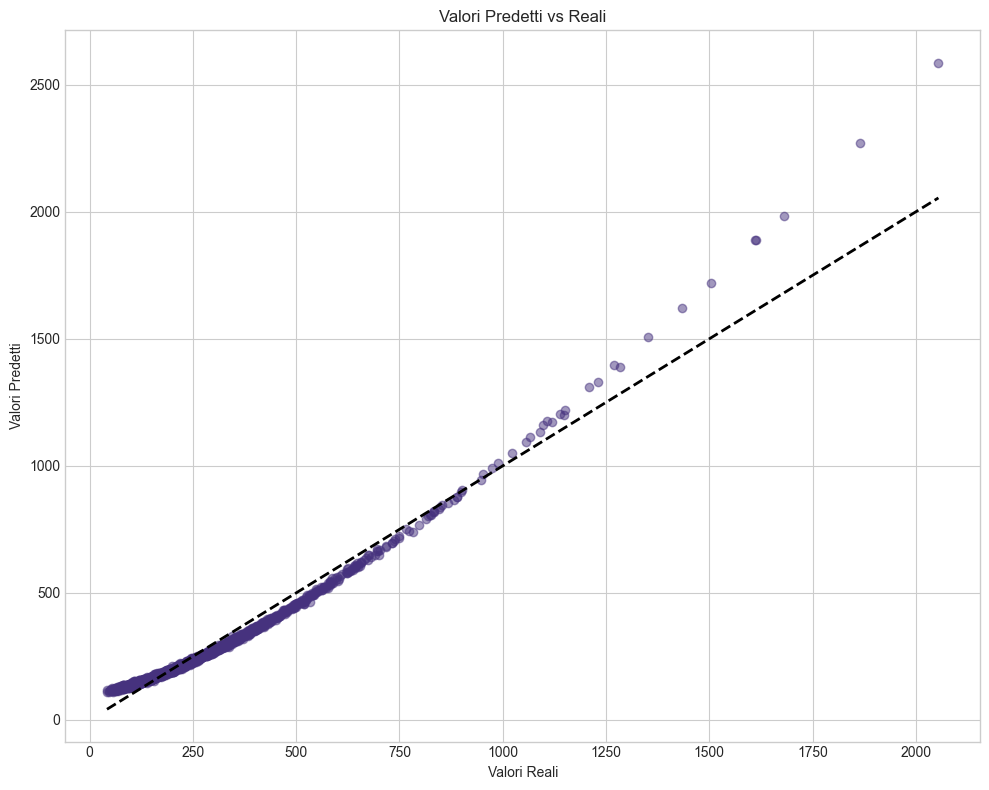

In [37]:
model = NormalizedNonLinearRegression(learning_rate=0.001, n_iterations=10000)

# Aggiungiamo le migliori trasformazioni individuate
model.add_transformation('ambient_temperature', lambda x: x ** 2)
model.add_transformation('sampling_frequency', lambda x: np.log1p(x))  # log(1+x) per gestire valori ≥ 0
model.add_transformation('device_age', lambda x: np.log1p(x))  # log(1+x) per gestire valori ≥ 0
model.add_transformation('signal_strength', lambda x: np.exp(np.clip(-x, -10, 10)))

# Addestriamo il modello
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Valutazione del modello
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"\nPerformance del modello:")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

# Visualizzazione dei valori predetti vs reali
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valori Reali')
plt.ylabel('Valori Predetti')
plt.title('Valori Predetti vs Reali')
plt.tight_layout()
plt.show()

I risultati mostrano che il modello non lineare ha ottenuto un ottimo R² di circa 0.96, indicando che il 96% della varianza nel consumo energetico è spiegata dal modello. L'RMSE è di circa 37, che rappresenta l'errore medio delle previsioni. Il grafico dei valori predetti vs reali mostra che i punti sono molto vicini alla linea diagonale ideale, confermando la buona qualità delle previsioni.
La trasformazione esponenziale della signal_strength ha avuto un impatto particolarmente positivo, catturando efficacemente la relazione non lineare con il consumo energetico.

16. Addestramento e Valutazione di un Modello Lineare per Confronto
Per confronto, addestriamo anche un modello lineare senza trasformazioni non lineari.

Avvio addestramento...
Iterazione 0: MSE = 48801.355039
Iterazione 100: MSE = 40729.262522
Iterazione 200: MSE = 34121.719301
Iterazione 300: MSE = 28712.982888
Iterazione 400: MSE = 24285.534132
Iterazione 500: MSE = 20661.325503
Iterazione 600: MSE = 17694.617821
Iterazione 700: MSE = 15266.117077
Iterazione 800: MSE = 13278.175382
Iterazione 900: MSE = 11650.862880
Iterazione 1000: MSE = 10318.752556
Iterazione 1100: MSE = 9228.288534
Iterazione 1200: MSE = 8335.631971
Iterazione 1300: MSE = 7604.897871
Iterazione 1400: MSE = 7006.711852
Iterazione 1500: MSE = 6517.028824
Iterazione 1600: MSE = 6116.166025
Iterazione 1700: MSE = 5788.011524
Iterazione 1800: MSE = 5519.376347
Iterazione 1900: MSE = 5299.464155
Iterazione 2000: MSE = 5119.437160
Iterazione 2100: MSE = 4972.060786
Iterazione 2200: MSE = 4851.412820
Iterazione 2300: MSE = 4752.645325
Iterazione 2400: MSE = 4671.789749
Iterazione 2500: MSE = 4605.597396
Iterazione 2600: MSE = 4551.408843
Iterazione 2700: MSE = 4507.04704

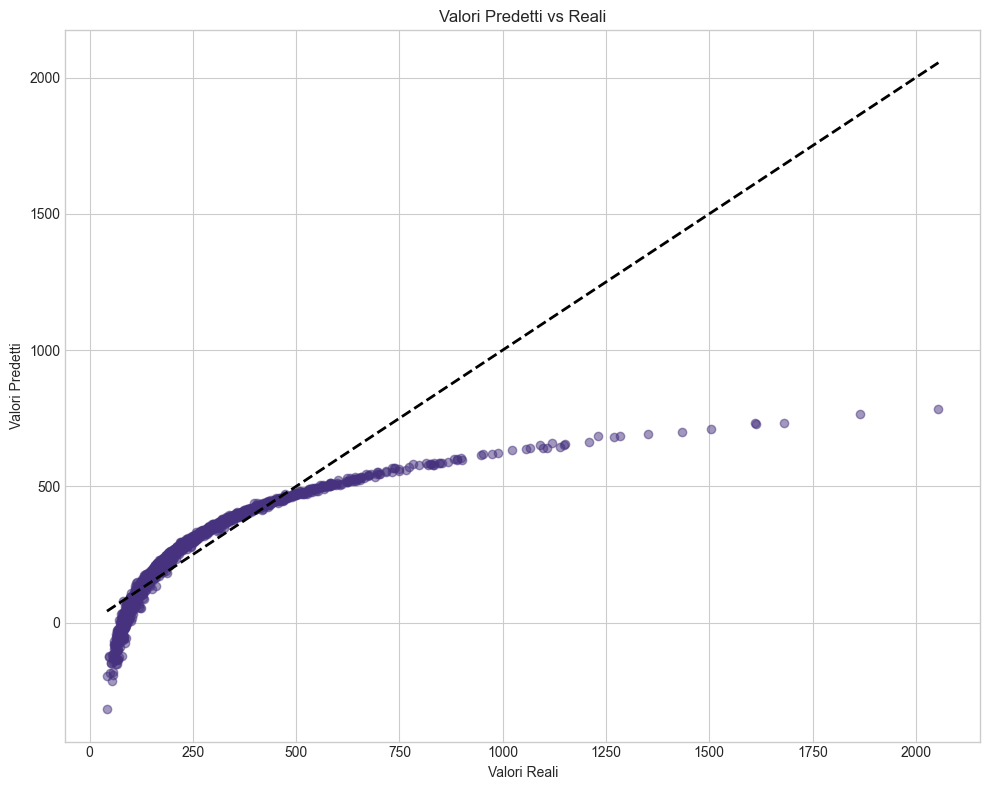

In [38]:
# Addestriamo il modello con le features selezionate
lr_model = LinearRegression(learning_rate=0.001, n_iterations=10000)
X_train_norm = (X_train - X_train.mean()) / X_train.std()
X_test_norm = (X_test - X_test.mean()) / X_test.std()
# Normalizzo i dati come ho fatto prima
lr_model.fit(X_train_norm, y_train)

# Predizioni sul test set
y_pred = lr_model.predict(X_test_norm)

# Valutazione del modello
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"\nPerformance del modello:")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

# Visualizzazione dei valori predetti vs reali
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valori Reali')
plt.ylabel('Valori Predetti')
plt.title('Valori Predetti vs Reali')
plt.tight_layout()
plt.show()



I risultati del modello lineare mostrano un R² di circa 0.74, significativamente inferiore rispetto al modello non lineare (0.96). Anche l'RMSE è molto più alto (circa 97 contro 37), indicando che le previsioni sono meno accurate. Il grafico dei valori predetti vs reali mostra una maggiore dispersione dei punti rispetto alla linea diagonale ideale.

#### Conclusioni
-1 Importanza dell'analisi esplorativa: Le visualizzazioni e le diverse metriche di correlazione ci hanno permesso di individuare relazioni non lineari che sarebbero state difficili da rilevare con metodi standard.

-2 Efficacia delle trasformazioni: Trasformare le variabili in modo appropriato (esponenziale, logaritmico, quadratico) può linearizzare le relazioni e migliorare significativamente le performance dei modelli.

-3 Superiorità del modello non lineare: Il confronto tra il modello lineare e non lineare ha dimostrato chiaramente il vantaggio di incorporare trasformazioni non lineari quando le relazioni sottostanti lo richiedono.

-4 Impatto della feature principale: Nel nostro caso, signal_strength è risultata la variabile più importante per predire il consumo energetico, con una forte relazione non lineare che è stata catturata efficacemente con una trasformazione esponenziale.

-5 Normalizzazione e pre-elaborazione: L'utilizzo di tecniche di normalizzazione ha contribuito ulteriormente a migliorare le performance del modello.